# Antes de empezar

conda activate python3.6_cv2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import cv2
#import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
import platform
print(torch.__version__)
print(platform.python_version())
torch.cuda.get_device_name(1)

1.8.1
3.6.10


'TITAN X (Pascal)'

## Cargando datos

In [112]:
# Loading preprocessed images

import h5py
filename = "/home/abarreiro/data/handwriting/seq2seq/IAM_words_48_192.hdf5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    data_header = list(f.keys())
    data = []
    
    for item in data_header:
        
        # Getting data:
        data.append(list(f[item]))
        
    # Creating dictionary between data names and data   
    new_dict = {name: obj for name, obj in zip(data_header, data)}


Keys: <KeysViewHDF5 ['X_trn', 'X_tst', 'X_val', 'filename_trn', 'filename_tst', 'filename_val', 'image_length_trn', 'image_length_tst', 'image_length_val', 'target_dict_keys', 'target_dict_values', 'target_length_trn', 'target_length_tst', 'target_length_val', 'target_trn', 'target_tst', 'target_val']>


In [113]:
print(new_dict['target_trn'][3])

[  9.  26.  58.  53. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]


In [114]:
print(len(new_dict['X_trn']))
print(new_dict['X_trn'][1].shape)
print(new_dict['target_dict_values'][1])
print(max(new_dict['target_length_trn'] + new_dict['target_length_val'] + new_dict['target_length_tst']))

47926
(48, 192)
b'!'
19


## Definiendo diccionario, codificación y longitud máxima

In [115]:
# Dictionary used in seq2seq paper
decoder_dict = {0: '0', 1: '!', 2: 'L', 3: 'z', 4: 'G', 5: 'm', 6: '6', 7: '/', 8: 'j', 9: 's', 10: 'S', 11: '5',
                12: 'R', 13: ')', 14: 'u', 15: 'y', 16: '9', 17: 'g', 18: '3', 19: '1', 20: 'e', 21: "'", 22: ':',
                23: 'Q', 24: '2', 25: 'a', 26: 't', 27: 'A', 28: '7', 29: ';', 30: 'i', 31: 'H', 32: 'W', 33: ',',
                34: '(', 35: 'O', 36: 'U', 37: 'K', 38: 'd', 39: '*', 40: '.', 41: '?', 42: 'q', 43: '-', 44: 'r',
                45: 'n', 46: '&', 47: 'C', 48: '"', 49: 'h', 50: 'v', 51: 'f', 52: 'E', 53: 'p', 54: 'x', 55: '+',
                56: 'w', 57: 'b', 58: 'o', 59: ' ', 60: 'B', 61: 'P', 62: 'D', 63: 'I', 64: 'J', 65: 'V', 66: 'N',
                67: 'M', 68: '8', 69: 'k', 70: 'c', 71: '4', 72: 'T', 73: 'X', 74: 'l', 75: 'Z', 76: 'F', 77: 'Y',
                78: 'START', 79: 'END', 100: 'PAD'}

inverse_decoder_dict = {v: k for k, v in decoder_dict.items()}

In [116]:
print(inverse_decoder_dict['END'])

79


In [117]:
# One_hot_mapping assigns to each number in decoder_dict its corresponding one-hot vector:

one_hot_mapping = {}

cont = 0
for item in decoder_dict:
    vector = torch.zeros(1, 1, len(decoder_dict))
    vector[0, 0, cont] = 1.0
    one_hot_mapping[item] = vector
    cont += 1

# Inverse_one_hot_mapping assigns to each one-hot vector its corresponding number in decoder_dict
inverse_one_hot_mapping = {v: k for k, v in one_hot_mapping.items()}

# One_hot_to_char assigns to each possible one-hot vector its corresponding character from decoder_dict
one_hot_to_char = {}

for one_hot, char in zip(inverse_one_hot_mapping, inverse_decoder_dict):
    
    one_hot_to_char[one_hot] = char   

In [118]:
print(one_hot_mapping[100])
print(one_hot_to_char[one_hot_mapping[100]])

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
PAD


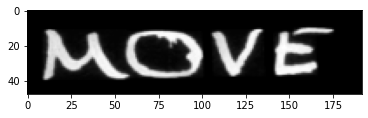

In [119]:
plt.imshow(new_dict['X_trn'][1], cmap='gray')

In [160]:
# All word vectors in 'target' are adjusted to max_length = 19:
a = [len(word) for word in new_dict['target_trn']]
print(np.unique(a))

MAX_LENGTH = np.unique(a)

[19]


In [121]:
def numpy_to_torch(array_list):
    tensor_list = []
    for array in array_list:
        tensor_list.append(torch.from_numpy(array))
        
    return tensor_list
    
a = numpy_to_torch(new_dict['target_trn'])
print(new_dict['target_trn'][0])
print(a[0])

X_trn = numpy_to_torch(new_dict['X_trn'])
X_val = numpy_to_torch(new_dict['X_val'])
X_tst = numpy_to_torch(new_dict['X_tst'])
target_trn = numpy_to_torch(new_dict['target_trn'])
target_val = numpy_to_torch(new_dict['target_val'])
target_tst = numpy_to_torch(new_dict['target_tst'])

print(new_dict['target_tst'][0])
print(target_tst[0])

[ 27. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
tensor([ 27., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)
[ 25.   9.   9.  14.  44.  20.  38.  45.  20.   9.   9. 100. 100. 100.
 100. 100. 100. 100. 100.]
tensor([ 25.,   9.,   9.,  14.,  44.,  20.,  38.,  45.,  20.,   9.,   9., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)


In [124]:
a = new_dict['target_trn'][0:2]

for j,word in enumerate(a):
    print(j)
    print(word)
        
print(type(new_dict['target_trn']))

b = []
for item in new_dict['target_trn']:
    b.append(torch.from_numpy(item))
    
print(type(b[0]))

0
[ 27. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
1
[ 67.  35.  65.  52. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
<class 'list'>
<class 'torch.Tensor'>


# Generando patches y etiquetas para muestra finita

In [10]:
def crear_imagen(word, height, width):
    
    image = np.zeros(shape = (height, width), dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30), 
                        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (255, 255, 255), 
                        thickness = 1, lineType = cv2.LINE_AA)  
    # image = skimage.util.random_noise(image, mode='s&p') # just in case we wanted to add some noise
    return image


def patch_gen(word, color_channels, height, width, patch_height, patch_width, stepsize):
    
    image = crear_imagen(word, height, width)
    image = torch.from_numpy(image)
    image = image / 255
        
    n_patches = int((width - patch_width)/stepsize + 1)
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)    
    
    start = 0
    
    for p in range(n_patches):
        
        patches_tensor[p, 0, :, :] = image[:, start:start + patch_width] # sliding window
        start += stepsize # updating the bottom-left position of the patch adding the stepsize
 
    return patches_tensor


def complete_set(word_set, color_channels, height, width, patch_height, patch_width, stepsize):
    
    complete_set = []
    
    for word in word_set: 
        
        word_tensor = patch_gen(word, color_channels, height, width, patch_height, patch_width, stepsize)
        complete_set.append((word_tensor, word))
        
    return complete_set


# Generando patches y etiquetas para muestra infinita aleatoria

In [11]:
def crear_imagen2(word, height, width):
    
    image = np.zeros(shape = (height, width), dtype = np.uint8)
    cv2.putText(image, text = word, org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (255, 255, 255),
        thickness = 1, lineType = cv2.LINE_AA)  
    # image = skimage.util.random_noise(image, mode='s&p') # just in case we wanted to add some noise
    return image


def patch_gen2(batch_element, word, color_channels, height, width, n_patches, 
               patch_height, patch_width, stepsize, patches_tensor):
    
    image = crear_imagen2(word, height, width)
    image = torch.from_numpy(image)
    image = image / 255
        
    start = 0
    
    for p in range(n_patches):
        
        patches_tensor[batch_element, p, 0, :, :] = image[:, start:start + patch_width] # sliding window
        start += stepsize # updating the bottom-left position of the patch adding the stepsize
 
    return patches_tensor

def complete_set2(word_set, batch_size, color_channels, height, width, patch_height, patch_width, stepsize):
    
    n_patches = int((width - patch_width)/stepsize + 1)
    
    patches_tensor = torch.empty(batch_size, n_patches, color_channels, patch_height, patch_width)
    word_list = []
    
    for batch_element, word in enumerate(word_set):
        
        patches_tensor = patch_gen2(batch_element, word, color_channels, height, width, n_patches, 
                                    patch_height, patch_width, stepsize, patches_tensor)
        word_list.append(word)

    return patches_tensor, word_list
    

In [12]:
comp_train_set = complete_set(train_set, color_channels = 1, height = 48, width = 192,
                              patch_height = 48, patch_width = 10, stepsize = 2)
 
comp_val_set = complete_set(val_set, color_channels = 1, height = 48, width = 192,
                            patch_height = 48, patch_width = 10, stepsize = 2)

comp_test_set = complete_set(test_set, color_channels = 1, height = 48, width = 192, 
                             patch_height = 48, patch_width = 10, stepsize = 2)

comp_test_set_2 = complete_set(test_set_2, color_channels = 1, height = 48, width = 192,
                               patch_height = 48, patch_width = 10, stepsize = 2)

torch.Size([16, 92, 1, 48, 10])
torch.Size([1472, 1, 48, 10])
talkin


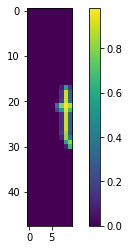

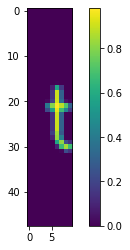

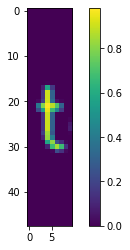

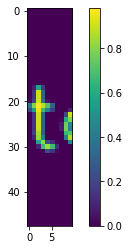

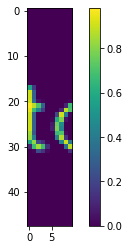

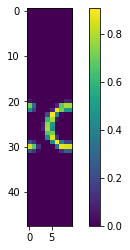

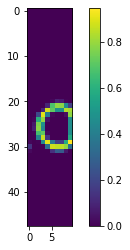

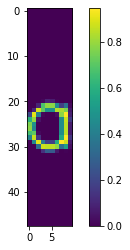

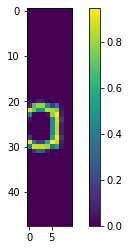

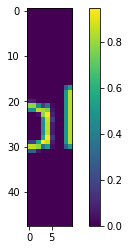

In [13]:
torch.manual_seed(1234)

train_loader = DataLoader(comp_train_set, batch_size = 16, shuffle = True, drop_last= True)
val_loader = DataLoader(comp_val_set, batch_size = 16, shuffle = False, drop_last= True)
test_loader = DataLoader(comp_test_set, batch_size = 16, shuffle = False, drop_last= True)
test_2_loader = DataLoader(comp_test_set_2, batch_size = 16, shuffle = False, drop_last= True)

for image, label in train_loader:
    break
    
#print(image)    
image_cnn = image.view(-1, 1, 48, 10)   
print(image.shape)
print(image_cnn.shape)
print(label[3])

for n_patch in range(0,10):
    patch = image[3,n_patch,0,:,:].cpu()
    plt.imshow(patch)
    plt.colorbar()
    plt.show()

In [14]:
def get_one_hot_target(labels, seq_len, output_size, batch_size):    
    one_hot_target = torch.empty(batch_size, seq_len, output_size) 

    for j,word in enumerate(labels):
        length = len(word)
        one_hot_target[j, 0, :] = mapeo['START']

        for k,letter in enumerate(word):
            one_hot_target[j, k + 1, :] = mapeo[letter]

        one_hot_target[j, length + 1, :] = mapeo['END']
        one_hot_target[j, length + 2: seq_len, :] = mapeo['PAD']
        
    return one_hot_target        

In [125]:
def get_one_hot_target_IAM(labels, seq_len, output_size, batch_size):
    # labels: tensor containing the labels of the words in the batch
    # each word label consists of a vector of length 19 (MAX LENGTH). The 19 elements are the encoded characters of the word
    # (according to Jorge's decoder dict, and completed with PADs to reach length = 19)
    one_hot_target = torch.empty(batch_size, seq_len, output_size) # future one-hot encoding tensor for the words of the batch
    START = inverse_decoder_dict['START'] # code number of the START token (according to Jorge's decoder_dict)
    END = inverse_decoder_dict['END']
    PAD = inverse_decoder_dict['PAD']
    
    for j, word in enumerate(labels):
        
        It_has_PADs = torch.any(word == PAD).item() # (majority case: the label vector of the word is completed with PADs)
        one_hot_target[j, 0, :] = one_hot_mapping[START] # START token's one-hot vector goes first
        
        for k, letter in enumerate(word):
            one_hot_target[j, k + 1, :] = one_hot_mapping[letter] # one-hot encoding of the rest of letters (including PADs)
            
        one_hot_target[j, -1, :] = one_hot_mapping[END] # last = END token
        
        if It_has_PADs == True: # if we had PADs
            
            array_of_PADs = torch.where(word == PAD)[0] 
            first_PAD = torch.min(array_of_PADs).item() # we store the first position where it appeared
            first_PAD = first_PAD + 1 # (recall that we added the START as first element, so the indices won't match)
            one_hot_target[j, first_PAD, :] = one_hot_mapping[END] # we replace that first PAD by an END
            one_hot_target[j, -1, :] = one_hot_mapping[PAD] # then the last element was a PAD, and not the END token
            
    return one_hot_target
                

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])

In [170]:
a = torch.empty(2, 21, len(decoder_dict))
a[0, 0, :] = one_hot_mapping[78]
a[1, 0, :] = one_hot_mapping[78]
a[0, 1:21, :] = one_hot_mapping[0]
a[1, 1:21, :] = one_hot_mapping[1]

print(torch.min(torch.where(target_tst[0]==inverse_decoder_dict['PAD'])[0]).item())
print(torch.where(target_tst[0]==100.)[0])

11
tensor([11, 12, 13, 14, 15, 16, 17, 18])


In [173]:
a = np.array([1,2,3,4])
print(torch.any(target_tst[0]==inverse_decoder_dict['PAD']).item())
#print(target_tst[0])
print(inverse_decoder_dict['START'])
START = inverse_decoder_dict['START']
print(one_hot_mapping[START])

True
78
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])


In [180]:
torch.cat((one_hot_mapping[0], one_hot_mapping[START]), dim=1)
#torch.cat((one_hot_mapping[START], one_hot_mapping[0]), dim=1)

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]]])

In [191]:
PAD = inverse_decoder_dict['PAD']
word = target_trn[1]
print(torch.any(word == PAD).item())
print(torch.where(word==PAD)[0])
print(word)
array_of_PADs = torch.where(word==PAD)[0]
first_PAD = torch.min(array_of_PADs).item()
print(first_PAD)

True
tensor([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
tensor([ 67.,  35.,  65.,  52., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.], dtype=torch.float64)
4


In [15]:
def one_hot_conversion(decoder_output, output_size):
    
    one_hot_output_letter = torch.zeros(1, 1, output_size)
    index = torch.argmax(decoder_output, dim = 2).item()
    one_hot_output_letter[0, 0, index] = 1.
    
    return one_hot_output_letter

# Definiendo la arquitectura

In [22]:
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self, IN_CHANNELS, FILTERS_CNN_1, NEURONS_IN_DENSE_LAYER,
                 PATCH_HEIGHT, PATCH_WIDTH, STRIDE, PADDING, KERNEL_SIZE):
        super().__init__()
        self.IN_CHANNELS = IN_CHANNELS
        self.FILTERS_CNN_1 = FILTERS_CNN_1
        self.NEURONS_IN_DENSE_LAYER = NEURONS_IN_DENSE_LAYER
        self.PATCH_HEIGHT_AFTER_POOLING = PATCH_HEIGHT//2
        self.PATCH_WIDTH_AFTER_POOLING = PATCH_WIDTH//2
        self.STRIDE = STRIDE
        self.PADDING = PADDING
        self.KERNEL_SIZE = KERNEL_SIZE
        
        self.conv1 = nn.Conv2d(in_channels = self.IN_CHANNELS, out_channels = self.FILTERS_CNN_1,
                               kernel_size = self.KERNEL_SIZE, stride = self.STRIDE, padding = self.PADDING)
        self.fc1 = nn.Linear(self.PATCH_HEIGHT_AFTER_POOLING * self.PATCH_WIDTH_AFTER_POOLING * self.FILTERS_CNN_1, 
                             self.NEURONS_IN_DENSE_LAYER)
        
    def forward(self, X):
        X = F.relu((self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.PATCH_HEIGHT_AFTER_POOLING*self.PATCH_WIDTH_AFTER_POOLING*self.FILTERS_CNN_1)
        X = self.fc1(X)

        return X

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, encoder_seq_len):        
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.seq_len = encoder_seq_len
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, batch_first = True)

    def forward(self, input, hidden):        
        output = input.view(self.batch_size, self.seq_len, self.input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
                torch.zeros(1, self.batch_size, self.hidden_size, device=device))

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, batch_size, decoder_seq_len):
        super(DecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.seq_len = decoder_seq_len

        self.lstm = nn.LSTM(self.output_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden):        
        output = input.view(self.batch_size, self.seq_len, self.output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
               torch.zeros(1, self.batch_size, self.hidden_size, device=device))

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p, batch_size, encoder_seq_len, decoder_seq_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.batch_size = batch_size
        self.encoder_seq_len = encoder_seq_len
        self.decoder_seq_len = decoder_seq_len
        
        self.attn = nn.Linear(self.output_size + self.hidden_size, self.encoder_seq_len)
        self.attn_combine = nn.Linear(self.output_size + self.hidden_size, self.output_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.output_size, self.hidden_size, batch_first = True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        
        inputs = inputs.view(self.batch_size, self.decoder_seq_len, self.output_size)
        inputs = self.dropout(inputs)
        
        decoder_hidden_states = hidden[0].view(self.batch_size, self.decoder_seq_len, self.hidden_size) #[0] -- hidden, not cell
        
        attn_weights = F.softmax(
            self.attn(torch.cat((inputs, decoder_hidden_states), 2)), dim = 2)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        output = torch.cat((inputs, attn_applied), 2)
        output = self.attn_combine(output)

        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output), dim = 2)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(1, self.batch_size, self.hidden_size, device=device),
               torch.zeros(1, self.batch_size, self.hidden_size, device=device))

In [20]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_size, hidden_size, batch_size, n_patches, MAX_LENGTH, n_layers, drop_prob):
        super(BahdanauDecoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.enc_seq_len = n_patches
        self.dec_seq_len = MAX_LENGTH + 2
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        #self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        self.fc_hidden = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.fc_encoder = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.weight = nn.Parameter(torch.FloatTensor(self.batch_size, self.hidden_size, self.dec_seq_len))
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.drop_prob)
        self.lstm = nn.LSTM(self.output_size + self.hidden_size, self.hidden_size, batch_first=True)
        self.classifier = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        #encoder_outputs = encoder_outputs.squeeze()
        # Embed input words
        #embedded = self.embedding(inputs).view(1, -1)
        inputs = self.dropout(inputs)
        output = inputs.view(self.batch_size, self.dec_seq_len, self.output_size)

        # Calculating Alignment Scores
        hidden_state = hidden[0].view(self.batch_size, n_layers, self.hidden_size) # hidden[0] --> picking h. state and not cell
        x = torch.tanh(self.fc_hidden(hidden_state) + self.fc_encoder(encoder_outputs)) # shape: [batch, seq_len, hidden_size]
        #alignment_scores = x.bmm(self.weight.unsqueeze(2))  
        alignment_scores = torch.bmm(x, self.weight) # shape: [batch, enc_seq, dec_seq]
        
        # Softmaxing alignment scores to get Attention weights
        #attn_weights = F.softmax(alignment_scores.view(1,-1), dim=1)
        
        attn_weights = F.softmax(alignment_scores, dim = 1)

        # Multiplying the Attention weights with encoder outputs to get the context vector
        #context_vector = torch.bmm(attn_weights.unsqueeze(0),
        #                         encoder_outputs.unsqueeze(0))
        context_vector = torch.bmm(attn_weights.view(self.batch_size, self.dec_seq_len, self.enc_seq_len), 
                                   encoder_outputs)
        
        
        # Concatenating context vector with embedded input word
        #output = torch.cat((embedded, context_vector[0]), 1).unsqueeze(0)
        
        output = torch.cat((output, context_vector), dim=2)
        
        # Passing the concatenated vector as input to the LSTM cell
        output, hidden = self.lstm(output, hidden)
        # Passing the LSTM output through a Linear layer acting as a classifier
        #output = F.log_softmax(self.classifier(output[0]), dim=1)
        
        output = F.log_softmax(self.classifier(output), dim = 2)
        
        return output, hidden, attn_weights

In [23]:
torch.manual_seed(1234)

CNN_model = ConvolutionalNetwork(IN_CHANNELS = 1, FILTERS_CNN_1 = 4, NEURONS_IN_DENSE_LAYER = 1024, 
                                 PATCH_HEIGHT = 48, PATCH_WIDTH = 10, STRIDE = 1, PADDING = 0, KERNEL_SIZE = 1).cuda(1)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters())

Encoder_model = EncoderRNN(input_size = 1024, hidden_size = 256, batch_size = 16, encoder_seq_len = 92).cuda(1)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = AttnDecoderRNN(output_size = len(letters), hidden_size = 256, dropout_p = 0.1, batch_size = 16,
                               encoder_seq_len = 92, decoder_seq_len = 1).cuda(1)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

## Entrenando

In [24]:
import time

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [25]:
def calculate_loss(decoder_output, ground_truth, batch_size):
    loss = 0
        
    for j in range(batch_size):
        loss += criterion(decoder_output[j], ground_truth[j])               
    
    loss = loss/batch_size

    return loss

In [26]:
def train():
    train_losses = []
    for num_batch, (image, labels) in enumerate(train_loader):        
        num_batch += 1
        encoder_hidden = Encoder_model.initHidden()

        image_cnn = image.view(-1, 1, 48, 10).cuda(1)
        encoder_input = CNN_model(image_cnn)
        encoder_outputs, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
        
        
        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target(labels=labels, seq_len = MAX_LENGTH + 2, output_size = 29, batch_size = 16).cuda(1)
        
        
        for num_letter in range(MAX_LENGTH + 2):
            
            decoder_input_letter = decoder_input[:, num_letter, :].unsqueeze(1)
            
            decoder_output, decoder_hidden, attn_weights = Decoder_model(decoder_input_letter, decoder_hidden, encoder_outputs)
            
            if num_letter == 0:
                
                decoder_output_total = decoder_output
                
            else:
                
                decoder_output_total = torch.cat((decoder_output_total, decoder_output), dim = 1)

        output_indices = torch.tensor(list(range(0, MAX_LENGTH + 2 -1))).cuda(1) # removing last token from the output
        decoder_output = torch.index_select(decoder_output_total, dim = 1, index = output_indices)

        ground_truth = torch.argmax(decoder_input, dim = 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove SOS token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)

        loss = calculate_loss(decoder_output, ground_truth, 16)

        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        loss.backward()
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        train_losses.append(loss.item())
        
    return np.mean(train_losses)

In [27]:
def validation():
    valid_losses = []

    with torch.no_grad():       
        for num_batch_val, (image_val, labels_val) in enumerate(val_loader):        
            num_batch_val += 1
            encoder_hidden_val = Encoder_model.initHidden()
            image_cnn_val = image_val.view(-1, 1, 48, 10).cuda(1)
            encoder_input_val = CNN_model(image_cnn_val)
            encoder_outputs_val, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val)
        
            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target(labels=labels_val, seq_len = MAX_LENGTH + 2, output_size = 29, batch_size = 16).cuda(1)
            
            
            for num_letter_val in range(MAX_LENGTH + 2):
            
                decoder_input_letter_val = decoder_input_val[:, num_letter_val, :].unsqueeze(1)

                decoder_output_val, decoder_hidden_val, attn_weights_val = Decoder_model(decoder_input_letter_val, decoder_hidden_val, encoder_outputs_val)

                if num_letter_val == 0:

                    decoder_output_total_val = decoder_output_val

                else:

                    decoder_output_total_val = torch.cat((decoder_output_total_val, decoder_output_val), dim = 1)

            
            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH + 2 - 1))).cuda(1) # remove last token from the output
            decoder_output_val = torch.index_select(decoder_output_total_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, dim = 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(1) # remove START token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            
            loss_val = calculate_loss(decoder_output_val, ground_truth_val, 16)
            valid_losses.append(loss_val.item())
    return np.mean(valid_losses)

In [28]:
class Patience():
    
    def __init__(self, patience):
        self.patience = patience
        self.current_patience = patience
        self.min_loss_val = float('inf')

    def more_patience(self,loss_val):
        self.current_patience -= 1
        if self.current_patience == 0:
            return False

        if loss_val < self.min_loss_val:
            self.min_loss_val = loss_val
            self.current_patience = patience

            model_name = f"{48}x{192}_by{10}_jump{2}_batch{16} NN_{4}_{1024}_{1}_{256} pats:{30000}"
            print(", saved best model.")
            
            torch.save({
                'CNN_model_state_dict': CNN_model.state_dict(),
                'CNN_optimizer_state_dict': CNN_optimizer.state_dict(),
                'Encoder_model_state_dict': Encoder_model.state_dict(),
                'Encoder_optimizer_state_dict': Encoder_optimizer.state_dict(),
                'Decoder_model_state_dict': Decoder_model.state_dict(),
                'Decoder_optimizer_state_dict': Decoder_optimizer.state_dict(),
            }, 'Attention'+model_name)
            
            torch.save(CNN_model.state_dict(), 'CNN_'+model_name)
            torch.save(Encoder_model.state_dict(), 'Encoder_'+model_name)
            torch.save(Decoder_model.state_dict(), 'Decoder_'+model_name)
    
        return True

In [ ]:
torch.manual_seed(1234)
patience = 2000

patience_controler = Patience(patience)
start_time = time.time()

for num_epoch in range(5000000):
    train_loss = train()        
    valid_loss = validation()
    
    writer.add_scalar('Loss/train', train_loss, num_epoch)
    writer.add_scalar('Loss/validation', valid_loss, num_epoch)
    
    print(f'Epoch: {num_epoch} Train loss: {train_loss} Valid loss: {valid_loss} Duration: {(time.time() - start_time)/60} minutes',)

    if not patience_controler.more_patience(valid_loss):
        print("Se acabó la paciencia")
        break

        


Epoch: 0 Train loss: 2.0262378012793403 Valid loss: 1.6751467797064012 Duration: 1.5386393706003825 minutes
, saved best model.
Epoch: 1 Train loss: 1.552234000137874 Valid loss: 1.5168633768635411 Duration: 3.077888282140096 minutes
, saved best model.
Epoch: 2 Train loss: 1.4525571486609323 Valid loss: 1.449219826729067 Duration: 4.6056791067123415 minutes
, saved best model.
Epoch: 3 Train loss: 1.397971453973225 Valid loss: 1.4091694460761162 Duration: 6.135940114657084 minutes
, saved best model.
Epoch: 4 Train loss: 1.362684862749917 Valid loss: 1.3791308249196699 Duration: 7.664021257559458 minutes
, saved best model.
Epoch: 5 Train loss: 1.3380408314296177 Valid loss: 1.3577364269764192 Duration: 9.190347679456075 minutes
, saved best model.
Epoch: 6 Train loss: 1.3142182426452638 Valid loss: 1.336282085026464 Duration: 10.717403169473013 minutes
, saved best model.
Epoch: 7 Train loss: 1.2899985041618347 Valid loss: 1.3166916216573408 Duration: 12.240926973025005 minutes
, sav

Epoch: 65 Train loss: 0.6793209478514535 Valid loss: 0.7244130916172459 Duration: 98.96332377195358 minutes
, saved best model.
Epoch: 66 Train loss: 0.6744405015196119 Valid loss: 0.7187133575639417 Duration: 100.43000594774882 minutes
, saved best model.
Epoch: 67 Train loss: 0.6693591668605804 Valid loss: 0.7139950673426351 Duration: 101.93579049905141 minutes
, saved best model.
Epoch: 68 Train loss: 0.6646596863951002 Valid loss: 0.708914692844114 Duration: 103.40894486109416 minutes
, saved best model.
Epoch: 69 Train loss: 0.6598620338950838 Valid loss: 0.7041470898735908 Duration: 104.91827701330185 minutes
, saved best model.
Epoch: 70 Train loss: 0.6551266946281705 Valid loss: 0.7006894801893542 Duration: 106.40257918437322 minutes
, saved best model.
Epoch: 71 Train loss: 0.649954145022801 Valid loss: 0.6940914555903404 Duration: 107.88934723536174 minutes
, saved best model.
Epoch: 72 Train loss: 0.6447508984633854 Valid loss: 0.6951710403926911 Duration: 109.36372276147206

Epoch: 132 Train loss: 0.4481978247676577 Valid loss: 0.5035820540881926 Duration: 198.67293951511382 minutes
, saved best model.
Epoch: 133 Train loss: 0.45093062539611545 Valid loss: 0.5086714680637082 Duration: 200.09999171495437 minutes
Epoch: 134 Train loss: 0.45232991268805095 Valid loss: 0.5071390944142495 Duration: 201.59702812433244 minutes
Epoch: 135 Train loss: 0.4490302226969174 Valid loss: 0.4983093325168856 Duration: 203.08419292767843 minutes
, saved best model.
Epoch: 136 Train loss: 0.4438482653583799 Valid loss: 0.49888236580356476 Duration: 204.58079372644426 minutes
Epoch: 137 Train loss: 0.44223463428871973 Valid loss: 0.49515367083011136 Duration: 206.07934842507044 minutes
, saved best model.
Epoch: 138 Train loss: 0.43981887263059616 Valid loss: 0.4883588946634723 Duration: 207.58512667020162 minutes
, saved best model.
Epoch: 139 Train loss: 0.43345798206329345 Valid loss: 0.4879675012442373 Duration: 209.09300603866578 minutes
, saved best model.
Epoch: 140 Tr

Epoch: 198 Train loss: 0.29415324132357323 Valid loss: 0.34672690639572756 Duration: 297.0524024883906 minutes
, saved best model.
Epoch: 199 Train loss: 0.2921852967951979 Valid loss: 0.3460968806137962 Duration: 298.50347618261975 minutes
, saved best model.
Epoch: 200 Train loss: 0.29042069648844854 Valid loss: 0.34322397098425894 Duration: 300.00827283064524 minutes
, saved best model.
Epoch: 201 Train loss: 0.2887121055041041 Valid loss: 0.34188925402779735 Duration: 301.5164472063382 minutes
, saved best model.
Epoch: 202 Train loss: 0.2862545535138675 Valid loss: 0.33895448811592593 Duration: 303.02321326732635 minutes
, saved best model.
Epoch: 203 Train loss: 0.2847559034824371 Valid loss: 0.33722089543457956 Duration: 304.5336232662201 minutes
, saved best model.
Epoch: 204 Train loss: 0.28297613781690595 Valid loss: 0.3363954563054346 Duration: 305.98781937360764 minutes
, saved best model.
Epoch: 205 Train loss: 0.28137518805691175 Valid loss: 0.3324240249010824 Duration: 3

Epoch: 263 Train loss: 0.20080649611779622 Valid loss: 0.25687064230442047 Duration: 393.94684640963874 minutes
Epoch: 264 Train loss: 0.19913340354391507 Valid loss: 0.2477531341775771 Duration: 395.4045862555504 minutes
, saved best model.
Epoch: 265 Train loss: 0.19889218302709716 Valid loss: 0.24720956192862603 Duration: 396.90022894144056 minutes
, saved best model.
Epoch: 266 Train loss: 0.19720017644762994 Valid loss: 0.24762756641834013 Duration: 398.3910961906115 minutes
Epoch: 267 Train loss: 0.1966570158238922 Valid loss: 0.24563330087450244 Duration: 399.8894765297572 minutes
, saved best model.
Epoch: 268 Train loss: 0.1956399308698518 Valid loss: 0.2463655235065568 Duration: 401.3858583251635 minutes
Epoch: 269 Train loss: 0.19458618102754865 Valid loss: 0.2453583695234791 Duration: 402.89167675177254 minutes
, saved best model.
Epoch: 270 Train loss: 0.1937352590156453 Valid loss: 0.24260483862411591 Duration: 404.39323863188423 minutes
, saved best model.
Epoch: 271 Tra

Epoch: 331 Train loss: 0.14590332413784096 Valid loss: 0.19458567819768383 Duration: 495.22905847231544 minutes
, saved best model.
Epoch: 332 Train loss: 0.14547941101874623 Valid loss: 0.19727913686825382 Duration: 496.72575150330863 minutes
Epoch: 333 Train loss: 0.1447943799772433 Valid loss: 0.19344086079828202 Duration: 498.23112214803695 minutes
, saved best model.
Epoch: 334 Train loss: 0.14427110324800013 Valid loss: 0.19504367818515148 Duration: 499.72946886618934 minutes
Epoch: 335 Train loss: 0.14382646058712686 Valid loss: 0.19078317128362193 Duration: 501.2335102478663 minutes
, saved best model.
Epoch: 336 Train loss: 0.14287509240210056 Valid loss: 0.19950769312920108 Duration: 502.73219503561654 minutes
Epoch: 337 Train loss: 0.14202245113466466 Valid loss: 0.19390439368303744 Duration: 504.2305729230245 minutes
Epoch: 338 Train loss: 0.14175182256315436 Valid loss: 0.19005418556832498 Duration: 505.7311152299245 minutes
, saved best model.
Epoch: 339 Train loss: 0.140

Epoch: 401 Train loss: 0.10618273550271988 Valid loss: 0.15605718101705274 Duration: 599.5763759493827 minutes
Epoch: 402 Train loss: 0.10578736566432885 Valid loss: 0.15279246118640707 Duration: 601.0417279084523 minutes
Epoch: 403 Train loss: 0.1051981945027198 Valid loss: 0.15133381544822647 Duration: 602.5103176951409 minutes
Epoch: 404 Train loss: 0.10471241310025964 Valid loss: 0.15068848968874063 Duration: 604.0039936741193 minutes
, saved best model.
Epoch: 405 Train loss: 0.10422975670014109 Valid loss: 0.14919370250596153 Duration: 605.4770634651184 minutes
, saved best model.
Epoch: 406 Train loss: 0.10392719157998051 Valid loss: 0.15234953531574819 Duration: 606.9761199990909 minutes
Epoch: 407 Train loss: 0.1033229670396873 Valid loss: 0.14772393791786126 Duration: 608.4732955932617 minutes
, saved best model.
Epoch: 408 Train loss: 0.10281627149454185 Valid loss: 0.14934339004779054 Duration: 609.9594308972358 minutes
Epoch: 409 Train loss: 0.10392021191758768 Valid loss:

## Cargar modelo

In [ ]:
CNN_model.load_state_dict(torch.load('CNN_model_30000_words_TF_PAD_noise.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_30000_words_TF_PAD_noise.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_30000_words_TF_PAD_noise.pt'))
Decoder_model.eval()

In [3]:
def Test():
    with torch.no_grad():
        for num_batch, (image_test, label_test) in enumerate(test_loader):
            num_batch += 1
            encoder_hidden_test = Encoder_model.initHidden(batch_size = batch_size)
            image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(0)
            encoder_input_test = CNN_model(image_cnn_test)
            encoder_output, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch = test_batch, seq_len = n_patches)

            #decoder_hidden_test = (encoder_hidden_test[0][0, :, :].view(1, batch_size, hidden_size), # We take the last hidden state of the Encoder 
            #                       encoder_hidden_test[1][0, :, :].view(1, batch_size, hidden_size)) # for each image/word (j) within the batch 
            
            for j in range(batch_size):
                decoder_input_test = mapeo['START'].cuda(0) # We initialize the first Decoder input as the START token
                decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                       encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the batch 
                
                for d in range(MAX_LENGTH + 2):
                    decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test, batch = 1, seq_len = 1)

                    output_letter = one_hot_conversion(decoder_output_test, output_size = output_size)
                    decoder_input_test = output_letter
                    
                    if d == 0:
                        output_word = output_letter
                    else:
                        output_word = torch.cat((output_word, output_letter), dim = 1).cuda(0)
                    
                    if torch.equal(output_letter, letter_to_vector('END').cuda(0)):
                        break
                output_word = torch.argmax(output_word, dim=2)
                output_word = output_word.view(output_word.numel()) # view as a rank-1 tensor

                model_word = []
                for item in output_word:
                    model_word.append(letters[item])

                model_word = ''.join(model_word[:-1])
                print(model_word)
            print(test_set) 


In [4]:
Test()

NameError: name 'torch' is not defined

In [21]:
list_random_strings = []
import random 
import string
batch_size = 256
MAX_LENGTH = 15

for i in range(batch_size):

    list_random_strings.append(''.join(random.choice(string.ascii_lowercase) for _ in range(random.randint(1, MAX_LENGTH))))

train_set = complete_set(list_random_strings)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

for b, (image, labels) in enumerate(train_loader):
    print(b)

    
torch.cat()

0


In [109]:
hidden = (torch.ones(1,1, 256), torch.zeros(1,1,256))
e_o = torch.ones(1, 15, 256)

In [110]:
hidden[0].shape

torch.Size([1, 1, 256])

In [111]:
e_o = e_o.squeeze()
fc_hidden = nn.Linear(256, 256, bias=False)
fc_encoder = nn.Linear(256, 256, bias=False)

c = fc_hidden(hidden[0]) + fc_encoder(e_o)
print(fc_hidden(hidden[0]).shape)
print(fc_encoder(e_o).shape)
print(c.shape)

torch.Size([1, 1, 256])
torch.Size([15, 256])
torch.Size([1, 15, 256])


In [ ]:
# activar pytorch_estoril (environment) en la terminal y ejecutar tensorboard --host 0.0.0.0 --logdir ./runs
# Tensorboard se ejecutará en un cierto puerto y nos dará el enlace. Habrá que sustituir la IP 0.0.0.0 por la del equipo
# en remoto en la que esté corriendo en el caso de Estoril 212.128.3.86: